<a href="https://colab.research.google.com/github/hsinjungheish/OS/blob/main/ece210_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework: Finite Differences** Hsin-Jung Hsieh


---


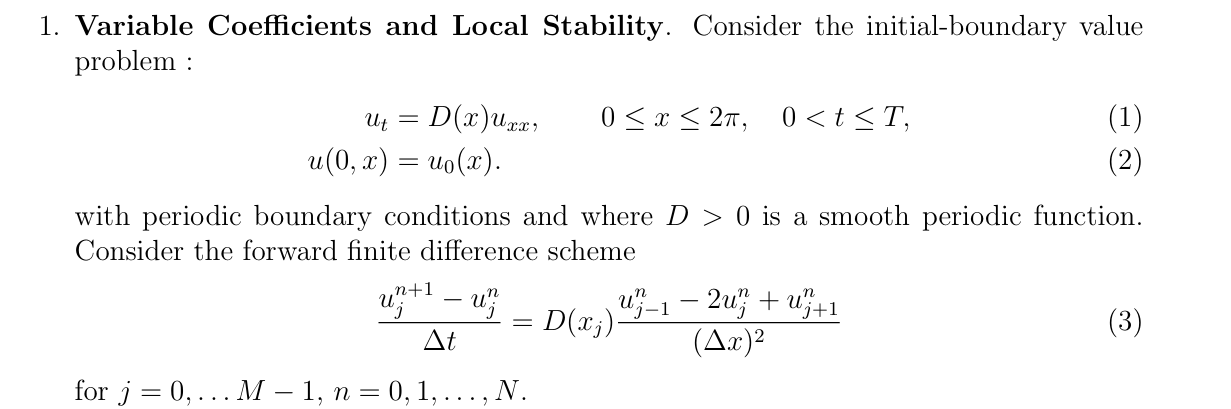

(a) Prove that the scheme (3) is consistent with (1) and find the method’s order of
 accuracy.

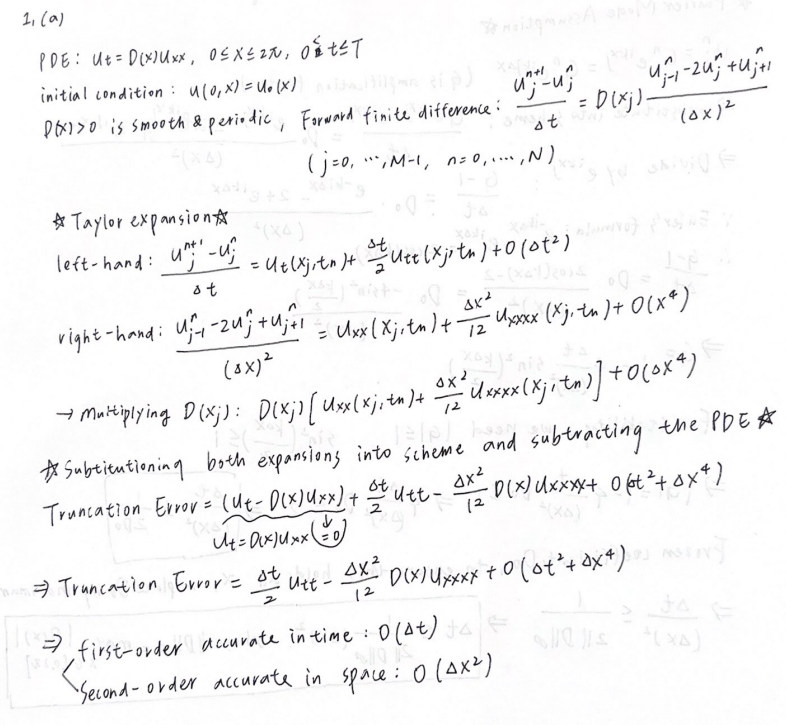



---


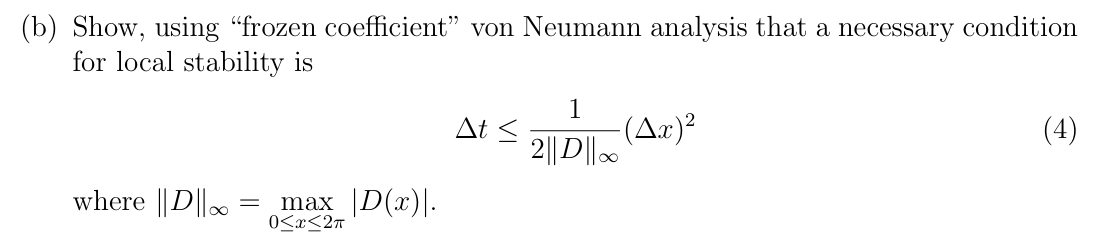

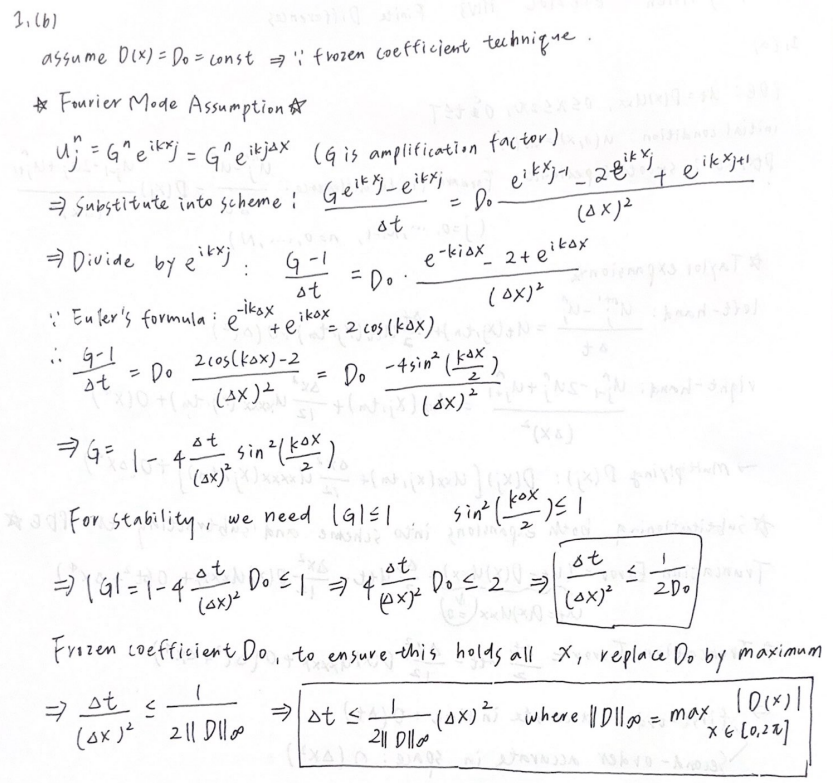



---


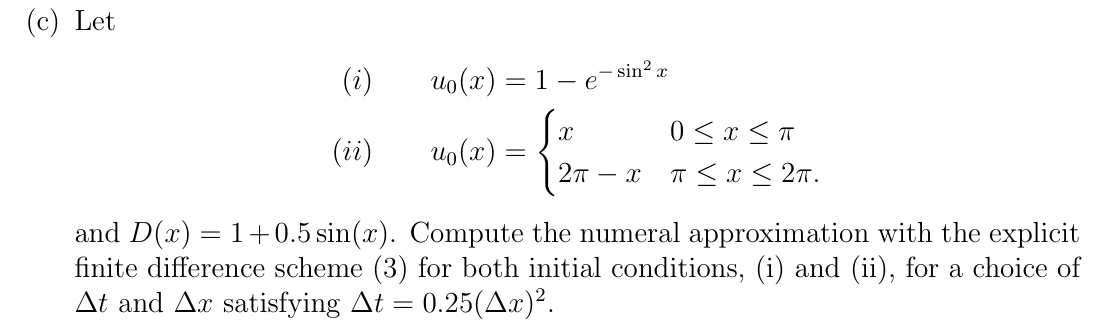

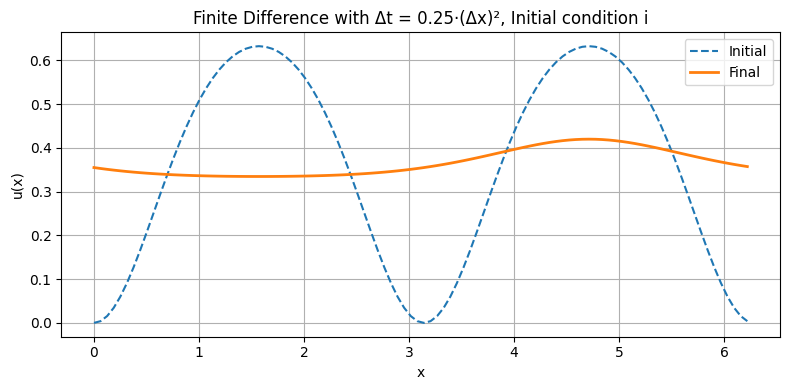

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters and Grid
L = 2 * np.pi
M = 100                          # Number of spatial points
x = np.linspace(0, L, M, endpoint=False)
dx = x[1] - x[0]
dt = 0.25 * dx**2
T = 1
N = int(T / dt)

# Initialize
which_initial = 'i'

if which_initial == 'i':
    u0 = 1 - np.exp(-np.sin(x)**2)
elif which_initial == 'ii':
    u0 = np.where(x <= np.pi, x, 2*np.pi - x)
else:
    raise ValueError("Choose either 'i' or 'ii' for the initial condition.")

D = 1 + 0.5 * np.sin(x)


# Time Stepping
u = u0.copy()

for n in range(N):
    u_next = u.copy()
    for j in range(M):
        jm = (j - 1) % M     # Left neighbor (periodic)
        jp = (j + 1) % M     # Right neighbor (periodic)
        u_next[j] = u[j] + dt * D[j] * (u[jm] - 2*u[j] + u[jp]) / dx**2
    u = u_next

plt.figure(figsize=(8, 4))
plt.plot(x, u0, label="Initial", linestyle='--')
plt.plot(x, u, label="Final", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Finite Difference with Δt = 0.25·(Δx)², Initial condition {which_initial}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---


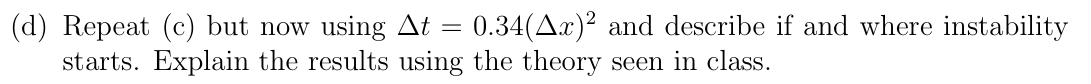

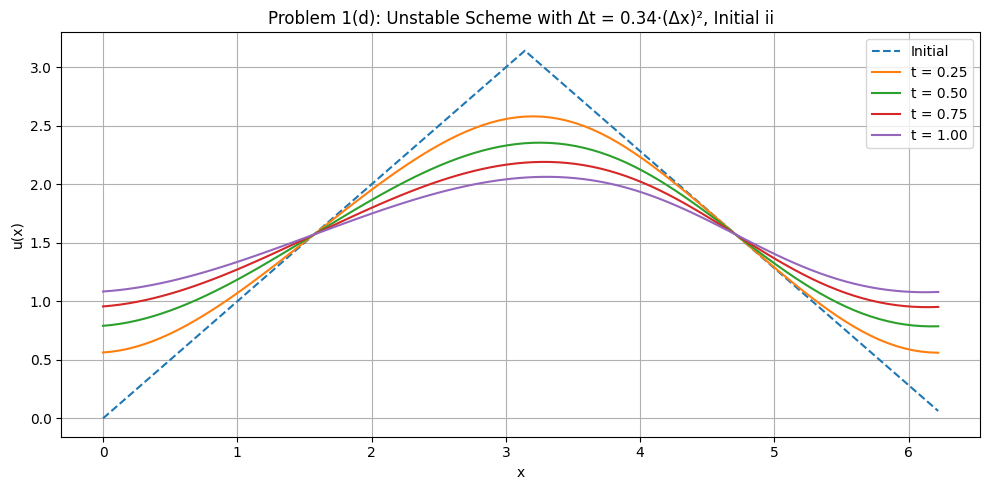

In [2]:
# Parameters and Grid
L = 2 * np.pi
M = 100
x = np.linspace(0, L, M, endpoint=False)
dx = x[1] - x[0]
dt = 0.34 * dx**2
T = 1
N = int(T / dt)

# Choose Initial Condition
which_initial = 'ii'

if which_initial == 'i':
    u0 = 1 - np.exp(-np.sin(x)**2)
elif which_initial == 'ii':
    u0 = np.where(x <= np.pi, x, 2*np.pi - x)
else:
    raise ValueError("Choose either 'i' or 'ii' for the initial condition.")

D = 1 + 0.5 * np.sin(x)

# Time Stepping
u = u0.copy()
snapshots = [u0.copy()]
times = [0.0]

for n in range(N):
    u_next = u.copy()
    for j in range(M):
        jm = (j - 1) % M
        jp = (j + 1) % M
        u_next[j] = u[j] + dt * D[j] * (u[jm] - 2*u[j] + u[jp]) / dx**2
    u = u_next
    # Save snapshots at a few times to see instability develop
    if n in [int(N*0.25), int(N*0.5), int(N*0.75), N-1]:
        snapshots.append(u.copy())
        times.append((n+1)*dt)

plt.figure(figsize=(10, 5))
plt.plot(x, u0, '--', label="Initial")
for u_snap, t in zip(snapshots[1:], times[1:]):
    plt.plot(x, u_snap, label=f"t = {t:.2f}")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Problem 1(d): Unstable Scheme with Δt = 0.34·(Δx)², Initial {which_initial}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In Problem 1(d), instability begins to appear gradually near the peaks of the solution, particularly around the sharp corners of the initial condition (ii), where the gradient is steepest. This is consistent with the theory taught in class: the explicit finite difference scheme is only conditionally stable, and increasing the time step beyond the stability threshold

$$
\Delta t \leq \frac{1}{2\|D\|_\infty} (\Delta x)^2
$$

causes numerical errors to grow. In this case,

$$
\Delta t = 0.34(\Delta x)^2
$$

violates that condition (since $\|D\|_\infty = 1.5$), leading to amplification of high-frequency error modes as predicted by von Neumann analysis. These errors accumulate most rapidly where the curvature is high or the diffusion coefficient $D(x)$ is largest, making the solution unstable over time.




---

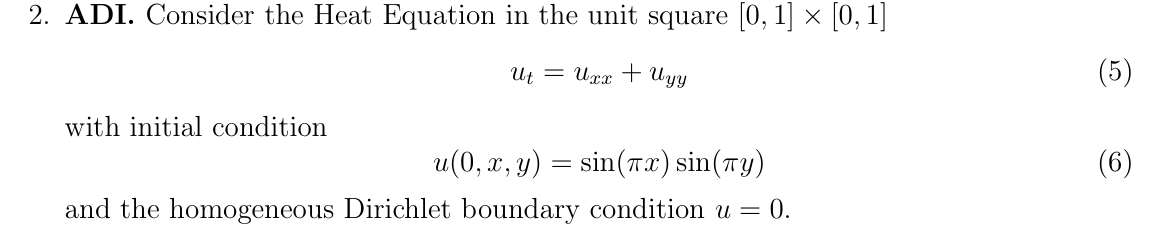



---

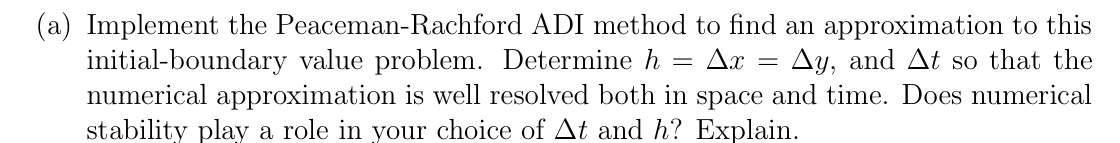

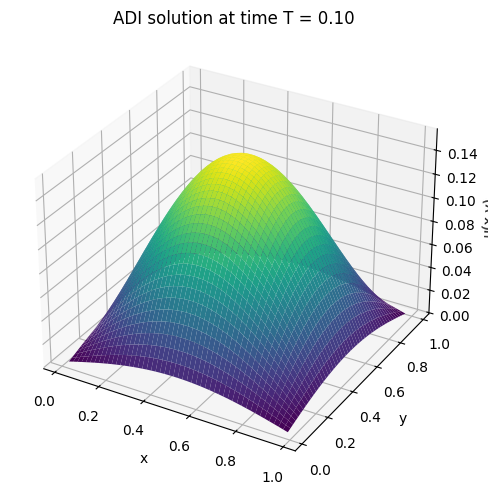

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

L = 1.0
M = 50
h = L / (M + 1)
x = np.linspace(h, L - h, M)
y = np.linspace(h, L - h, M)
X, Y = np.meshgrid(x, y)

dt = 0.001
T = 0.1
N = int(T / dt)


u = np.sin(np.pi * X) * np.sin(np.pi * Y)
r = dt / (2 * h**2)

lower = -r * np.ones(M - 1)
main  = (1 + 2*r) * np.ones(M)
upper = -r * np.ones(M - 1)
A_band = np.vstack([np.hstack([0, upper]),
                    main,
                    np.hstack([lower, 0])])

B_band = np.vstack([np.hstack([0, -upper]),
                    (1 - 2*r) * np.ones(M),
                    np.hstack([-lower, 0])])

# Time stepping loop
for n in range(N):
    # Step 1: implicit in x, explicit in y
    u_star = np.zeros_like(u)
    for j in range(M):
        rhs = (1 - 2*r) * u[:, j] + r * (np.roll(u[:, j], 1) + np.roll(u[:, j], -1))
        rhs[0] = rhs[0] - r * 0  # Dirichlet BCs
        rhs[-1] = rhs[-1] - r * 0
        u_star[:, j] = solve_banded((1, 1), A_band, rhs)

    # Step 2: implicit in y, explicit in x
    for i in range(M):
        rhs = (1 - 2*r) * u_star[i, :] + r * (np.roll(u_star[i, :], 1) + np.roll(u_star[i, :], -1))
        rhs[0] = rhs[0] - r * 0
        rhs[-1] = rhs[-1] - r * 0
        u[i, :] = solve_banded((1, 1), A_band, rhs)


fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u, cmap='viridis')
ax.set_title("ADI solution at time T = {:.2f}".format(T))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
plt.tight_layout()
plt.show()


In this implementation of the Peaceman–Rachford ADI method for solving the 2D heat equation, numerical stability does not strictly constrain the choice of time step $\Delta t$ because the ADI scheme is unconditionally stable. However, $\Delta t$ and $h$ (the spatial step size) still affect the \textbf{accuracy} of the solution: choosing $\Delta t$ too large or $h$ too coarse may lead to poor resolution of the solution’s time evolution and spatial features. In the code, we discretize the unit square using a uniform grid and initialize the solution with $u(0,x,y) = \sin(\pi x)\sin(\pi y)$. Each time step is split into two stages: the first solves a tridiagonal linear system implicitly in the $x$-direction and explicitly in $y$, while the second does the reverse. These alternating directions reduce computational cost while maintaining stability. The final result is visualized using a 3D surface plot showing the diffused heat distribution at the final time.




---

 (b) Verify the accuracy of a scheme numerically, i.e. do a resolution study to estimate
 the order of convergence of the method.

 M      h        Error       Rate
10     0.0909   6.6155e-02   -
20     0.0476   3.6666e-02   0.9126646644715392
40     0.0244   1.9401e-02   0.9513981663010834
80     0.0123   9.9827e-03   0.9758976641351721


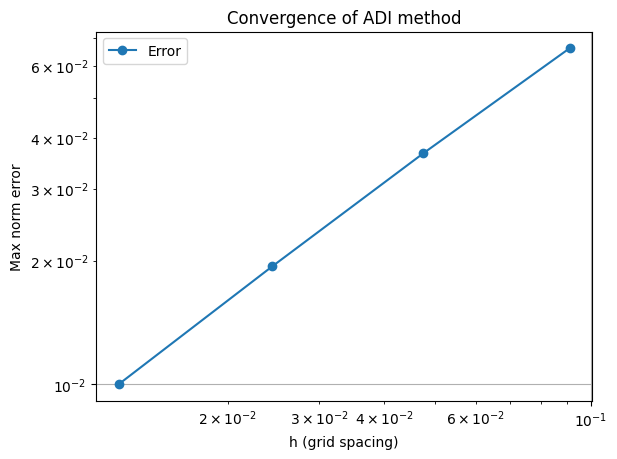

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

def adi_heat_solver(M, dt, T):
    h = 1 / (M + 1)
    x = np.linspace(h, 1 - h, M)
    y = np.linspace(h, 1 - h, M)
    X, Y = np.meshgrid(x, y)
    u = np.sin(np.pi * X) * np.sin(np.pi * Y)
    r = dt / (2 * h**2)
    N = int(T / dt)

    # Tridiagonal system for implicit solves
    lower = -r * np.ones(M - 1)
    main  = (1 + 2*r) * np.ones(M)
    upper = -r * np.ones(M - 1)
    A_band = np.vstack([np.hstack([0, upper]),
                        main,
                        np.hstack([lower, 0])])

    for n in range(N):
        u_star = np.zeros_like(u)
        for j in range(M):
            rhs = (1 - 2*r) * u[:, j] + r * (np.roll(u[:, j], 1) + np.roll(u[:, j], -1))
            u_star[:, j] = solve_banded((1, 1), A_band, rhs)

        for i in range(M):
            rhs = (1 - 2*r) * u_star[i, :] + r * (np.roll(u_star[i, :], 1) + np.roll(u_star[i, :], -1))
            u[i, :] = solve_banded((1, 1), A_band, rhs)


    exact = np.sin(np.pi * X) * np.sin(np.pi * Y) * np.exp(-2 * np.pi**2 * T)
    error = np.max(np.abs(u - exact))  # max norm
    return error, h


T = 0.1
dt = 0.001
grid_sizes = [10, 20, 40, 80]
errors = []
hs = []

for M in grid_sizes:
    err, h = adi_heat_solver(M, dt, T)
    errors.append(err)
    hs.append(h)


rates = [np.log(errors[i-1]/errors[i])/np.log(hs[i-1]/hs[i]) for i in range(1, len(errors))]


print(" M      h        Error       Rate")
for i in range(len(errors)):
    rate = rates[i-1] if i > 0 else "-"
    print(f"{grid_sizes[i]:<6} {hs[i]:.4f}   {errors[i]:.4e}   {rate}")


plt.loglog(hs, errors, 'o-', label="Error")
plt.grid(True)
plt.xlabel("h (grid spacing)")
plt.ylabel("Max norm error")
plt.title("Convergence of ADI method")
plt.legend()
plt.show()




---

 (c) Plot the numerical approximation at three times that illustrate well its time evolution.

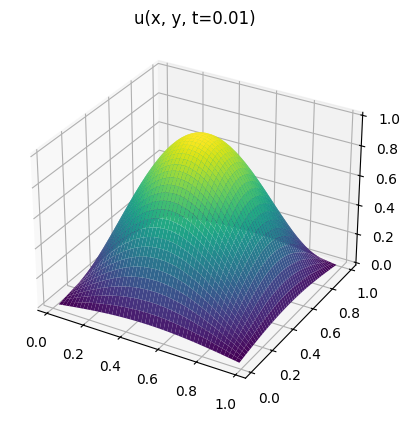

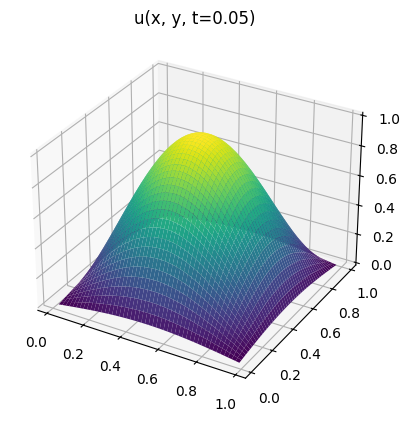

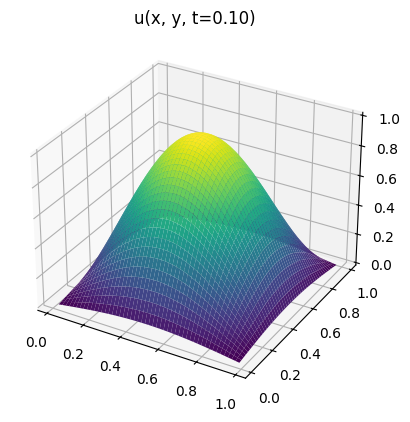

In [6]:
times_to_plot = [0.01, 0.05, 0.1]
u = np.sin(np.pi * X) * np.sin(np.pi * Y)
snapshots = []
r = dt / (2 * h**2)
N = int(T / dt)

for n in range(N):

    t = (n+1)*dt
    if np.isclose(t, times_to_plot[0], atol=dt/2):
        snapshots.append((t, u.copy()))
    if np.isclose(t, times_to_plot[1], atol=dt/2):
        snapshots.append((t, u.copy()))
    if np.isclose(t, times_to_plot[2], atol=dt/2):
        snapshots.append((t, u.copy()))

for t, u_snap in snapshots:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, u_snap, cmap='viridis')
    ax.set_title(f"u(x, y, t={t:.2f})")
    plt.show()




---

(d) If faced with this particular problem, which method would you choose to use ADI or Crank-Nicolson? Explain.


**Ans:** Between the ADI method and Crank–Nicolson for solving the 2D heat equation, the ADI method is generally preferred due to its efficiency. Crank–Nicolson in two dimensions requires solving a large sparse system at every time step, which can be computationally expensive. In contrast, the ADI method splits each time step into two one-dimensional implicit solves (tridiagonal), which are much faster and simpler to implement. Since both methods are unconditionally stable and second-order accurate, ADI offers the same accuracy and stability with significantly reduced computational cost, making it a better choice for large-scale or time-sensitive simulations.


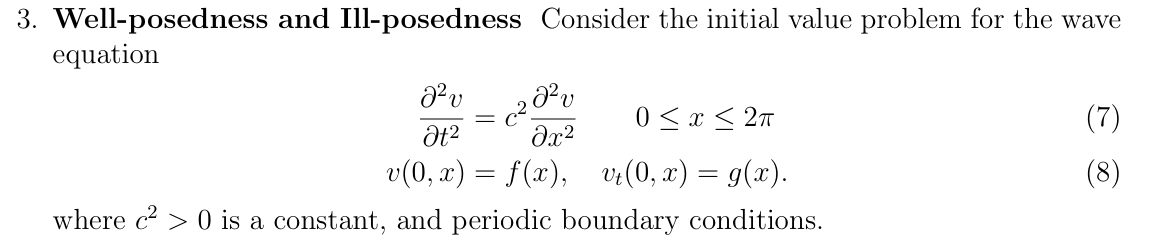



---

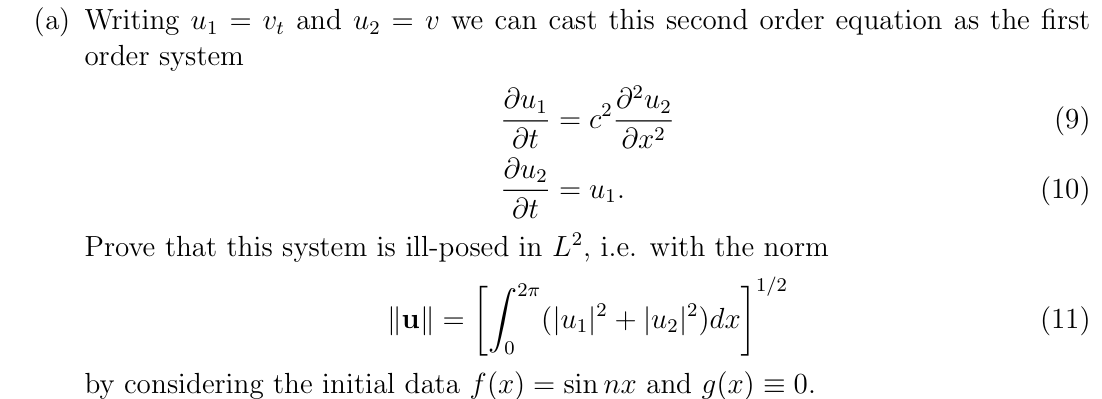

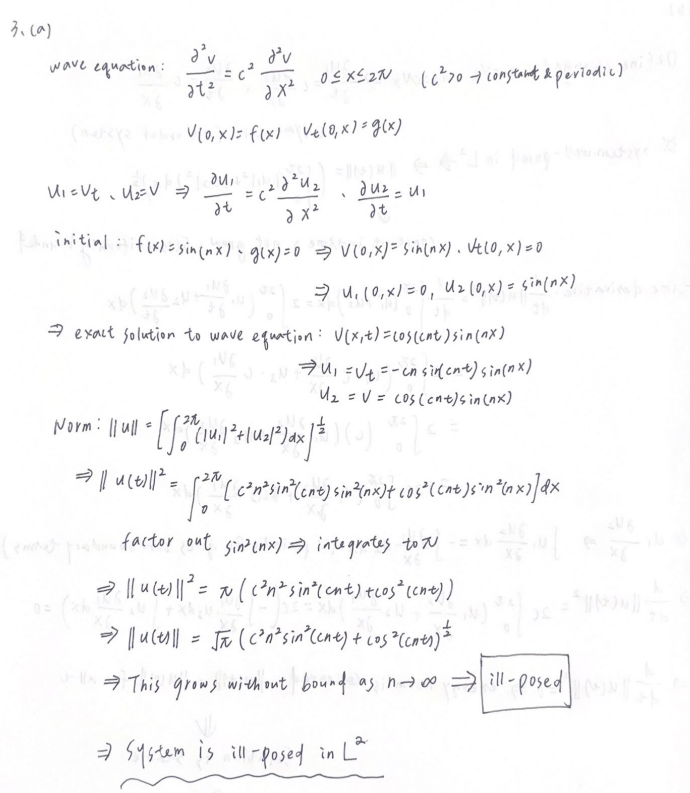



---


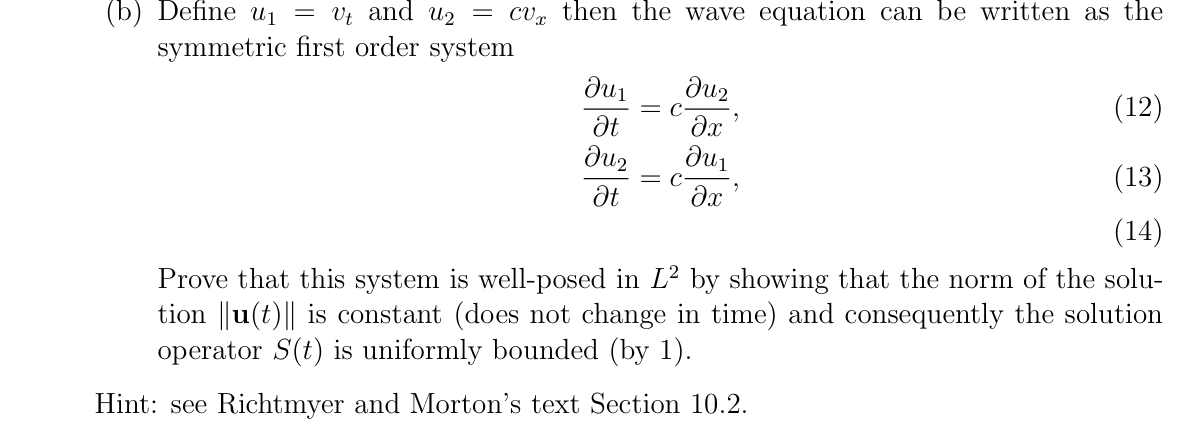

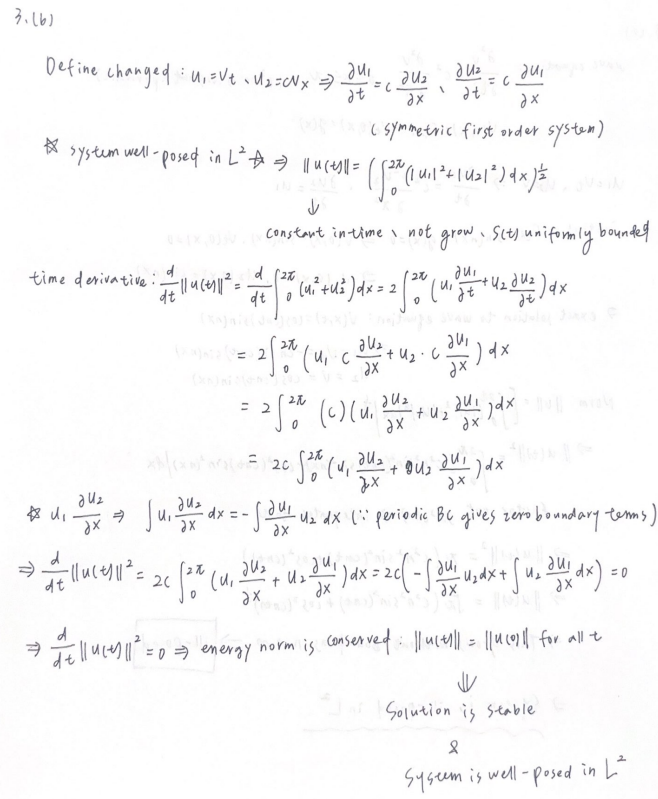